# 3. Multi-class Vnet on BV

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3.1 Setup Torch Global Variable, load memory map 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 1
NUM_WORKERS = 4
NUM_TRAIN = 80
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

In [9]:
#-------------------------LOAD THE DATA SET-------------------------------------------#

data_index = np.arange(107)
data_index = np.delete(data_index, 46)
dataset_trans = niiDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(4),
                             RandomFilp(0.5),
                             RandomAffine(15, 10)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([1, 1, 48, 64, 64]) torch.Size([1, 3, 48, 64, 64])
1 torch.Size([1, 1, 48, 64, 64]) torch.Size([1, 3, 48, 64, 64])
2 torch.Size([1, 1, 48, 64, 64]) torch.Size([1, 3, 48, 64, 64])
3 torch.Size([1, 1, 48, 64, 64]) torch.Size([1, 3, 48, 64, 64])


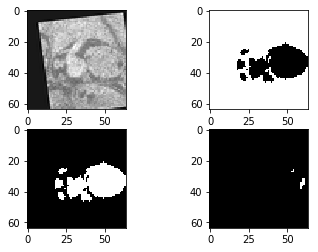

In [4]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    # observe 4th batch and stop.
    if i_batch == 3:
        show_batch_image(sample_batched['image'],sample_batched['label'],BATCH_SIZE)
        break

In [10]:
from vnet import VNet

#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

model = VNet(classnum=3, slim=True)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
shape_test(model, device, dtype)

In [ ]:
train(model, train_loader, validation_loader, optimizer,\
      device=device, dtype=dtype, epochs=100, print_every=16)

epoch 0 begins: 
Iteration 0, loss = 0.7607
Iteration 16, loss = 0.6242
epoch 0 ends with: 
validation loss = 0.5972
epoch 1 begins: 
Iteration 0, loss = 0.6463
Iteration 16, loss = 0.5902
epoch 1 ends with: 
validation loss = 0.5724
epoch 2 begins: 
Iteration 0, loss = 0.6187
Iteration 16, loss = 0.5986
epoch 2 ends with: 
validation loss = 0.5604
epoch 3 begins: 
Iteration 0, loss = 0.6054
Iteration 16, loss = 0.5904
epoch 3 ends with: 
validation loss = 0.5580
epoch 4 begins: 
Iteration 0, loss = 0.5930
Iteration 16, loss = 0.5684
epoch 4 ends with: 
validation loss = 0.5581
epoch 5 begins: 
Iteration 0, loss = 0.5793
Iteration 16, loss = 0.6360
epoch 5 ends with: 
validation loss = 0.5546
epoch 6 begins: 
Iteration 0, loss = 0.5881
Iteration 16, loss = 0.6031
epoch 6 ends with: 
validation loss = 0.5458
epoch 7 begins: 
Iteration 0, loss = 0.5510
Iteration 16, loss = 0.5934
epoch 7 ends with: 
validation loss = 0.5451
epoch 8 begins: 
Iteration 0, loss = 0.5865
Iteration 16, loss =

Iteration 0, loss = 0.3994
Iteration 16, loss = 0.4010
epoch 69 ends with: 
validation loss = 0.4125
epoch 70 begins: 
Iteration 0, loss = 0.3968
Iteration 16, loss = 0.4048
epoch 70 ends with: 
validation loss = 0.4001
epoch 71 begins: 
Iteration 0, loss = 0.4006
Iteration 16, loss = 0.3947
epoch 71 ends with: 
validation loss = 0.4130
epoch 72 begins: 
Iteration 0, loss = 0.3910
Iteration 16, loss = 0.3942
epoch 72 ends with: 
validation loss = 0.4051
epoch 73 begins: 
Iteration 0, loss = 0.4048
Iteration 16, loss = 0.3908
epoch 73 ends with: 
validation loss = 0.4196
epoch 74 begins: 
Iteration 0, loss = 0.3905
Iteration 16, loss = 0.3998
epoch 74 ends with: 
validation loss = 0.4064
epoch 75 begins: 
Iteration 0, loss = 0.3949
Iteration 16, loss = 0.4347
epoch 75 ends with: 
validation loss = 0.4045
epoch 76 begins: 
Iteration 0, loss = 0.3955
Iteration 16, loss = 0.4145
epoch 76 ends with: 
validation loss = 0.4005
epoch 77 begins: 
Iteration 0, loss = 0.3930
Iteration 16, loss = 